# Issues

---

## Summary

This notebook does some basic analysis of the issues found in the chosen repositories as well as our topic modeling process.

---

## Set-Up

### Necessary Imports

In [25]:
from gensim.corpora import Dictionary
from gensim.models import (CoherenceModel,
                           ldamulticore, )
from pyLDAvis import enable_notebook
from nltk.corpus import stopwords

import pyLDAvis.gensim
import spacy

In [26]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Settings

In [27]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
enable_notebook()

Pretty printing has been turned ON


### Globals

In [28]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
STOPS = stopwords.words("english")

# Append the Raft names
STOPS.extend(["tikv", "TiKV", "Tikv", "Hashicorp", "hashicorp", "HashiCorp", "pysyncobj", "PySyncObj", "Pysyncobj"])

In [29]:
# Topic modeling stuff
NUM_TOPICS = 30
PASSES = 4
CHUNK_SIZE = 2_000
SEED = 42
WORKERS = 8

In [30]:
PATH = "issues.csv"
issues = pd.read_csv(PATH)

In [31]:
issues.info()
issues.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5301 entries, 0 to 5300
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       5301 non-null   int64 
 1   STATUS   5301 non-null   object
 2   ISSUE    5301 non-null   object
 3   LABELS   4148 non-null   object
 4   UPDATED  5301 non-null   object
 5   REPO     5301 non-null   object
dtypes: int64(1), object(5)
memory usage: 248.6+ KB


,ID,STATUS,ISSUE,LABELS,UPDATED,REPO
0,586,OPEN,Leader election times seem too long with max c...,NaN,2024-03-06T10:34:55Z,/hashicorp/
1,585,OPEN,Allow network transfer of snapshot to be cance...,NaN,2024-02-28T20:15:22Z,/hashicorp/
2,578,CLOSED,Inconsistent Raft Latency on Different Infrast...,NaN,2023-10-30T22:10:40Z,/hashicorp/
3,576,CLOSED,Ability for peers to denote others/themselves ...,NaN,2023-10-17T17:25:44Z,/hashicorp/
4,574,CLOSED,Use pebbledb as raft logstore & stablestore; r...,NaN,2023-09-20T03:28:58Z,/hashicorp/


### Functions

In [32]:
def lemmatize(texts: pd.Series, pos: list[str]) -> list[list[str]]:
    return [[tok.lemma_ for tok in nlp(doc.lower()) if tok not in STOPS and tok.pos_ in pos] for doc in texts]

In [33]:
lemmatize(pd.Series(["I will Test this stuff please!", "He eats with me tomorrow"]), pos=["NOUN", "ADJ", "ADV", "VERB"])

[['test', 'stuff'], ['eat', 'tomorrow']]

---

## Clean-Up

In [34]:
issues.REPO = issues.REPO.map(lambda x: x[1:-1])
issues.REPO

0       hashicorp
1       hashicorp
2       hashicorp
3       hashicorp
4       hashicorp
          ...    
5296        bakwc
5297        bakwc
5298        bakwc
5299        bakwc
5300        bakwc
Name: REPO, Length: 5301, dtype: object

In [35]:
issues.UPDATED = issues.UPDATED.map(lambda x: datetime.datetime.fromisoformat(x).isoformat(timespec="seconds"))
issues.UPDATED

0       2024-03-06T10:34:55+00:00
1       2024-02-28T20:15:22+00:00
2       2023-10-30T22:10:40+00:00
3       2023-10-17T17:25:44+00:00
4       2023-09-20T03:28:58+00:00
                  ...            
5296    2016-07-04T07:52:16+00:00
5297    2016-06-12T03:25:47+00:00
5298    2018-10-28T18:45:28+00:00
5299    2016-04-05T15:15:37+00:00
5300    2016-04-04T09:35:04+00:00
Name: UPDATED, Length: 5301, dtype: object

In [36]:
issues.LABELS = issues.LABELS.fillna(value="").map(lambda x: x.split(';'))
issues.LABELS

0       []
1       []
2       []
3       []
4       []
        ..
5296    []
5297    []
5298    []
5299    []
5300    []
Name: LABELS, Length: 5301, dtype: object

---

## Exploration

<Axes: xlabel='REPO', ylabel='count'>

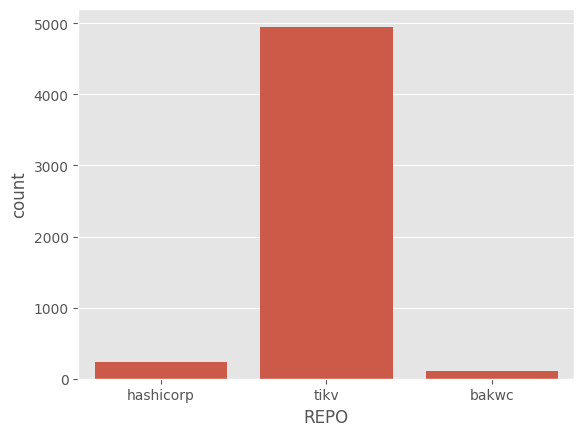

In [37]:
sns.countplot(data=issues, x='REPO')

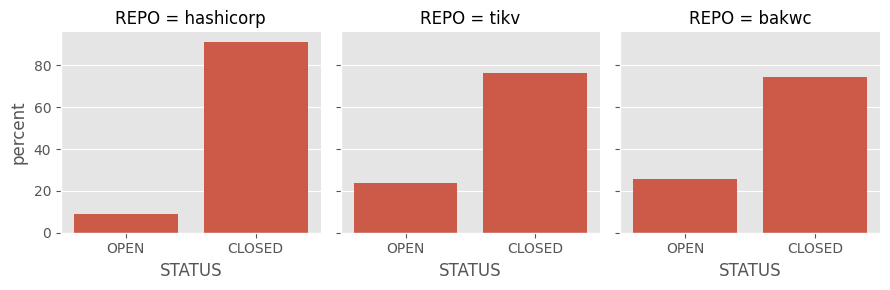

In [38]:
sns.FacetGrid(data=issues, col='REPO').map_dataframe(sns.countplot, x='STATUS', stat='percent')


In [39]:
issues.ISSUE[:4].to_list()

['Leader election times seem too long with max current term',
 'Allow network transfer of snapshot to be cancelled during shutdown',
 'Inconsistent Raft Latency on Different Infrastructures',
 'Ability for peers to denote others/themselves as too laggy to accept requests']

---

## GitHub Issue Topic Modeling

In [40]:
# Count word appearances and map types (words) to an index : (ind, count in document)
lemmas = lemmatize(issues.ISSUE, pos=["NOUN", "ADJ", "ADV", "VERB"])
d = Dictionary(lemmas)

In [41]:
Id = 1501
print(lemmas[Id])
print(d.doc2bow(lemmas[Id]))

['auto', 'sync', 'reset', 'version', 'finish', '20min', 'only', 'g', 'datum']
[(27, 1), (310, 1), (380, 1), (723, 1), (802, 1), (1061, 1), (1674, 1), (1680, 1), (1848, 1)]


In [42]:
# Transform into a bag of words for each document
corpus = [d.doc2bow(issue) for issue in lemmas]

In [43]:
corpus[Id]

[(27, 1),
 (310, 1),
 (380, 1),
 (723, 1),
 (802, 1),
 (1061, 1),
 (1674, 1),
 (1680, 1),
 (1848, 1)]

In [44]:
# How to get the word back
wid = corpus[Id][1][0]
d[wid]

'only'

In [45]:
model = ldamulticore.LdaMulticore(corpus=corpus, id2word=d, num_topics=NUM_TOPICS,
                                  chunksize=CHUNK_SIZE, passes=PASSES, 
                                  per_word_topics=True, random_state=SEED, workers=WORKERS)

/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.

/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


In [46]:
# Get the coherence score
coh_model = CoherenceModel(model=model, texts=lemmas, corpus=corpus, dictionary=d, coherence='c_v')
print(coh_model.get_coherence(), coh_model.get_coherence_per_topic())

/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=349215) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/computer_cat/miniconda3/envs/cs2510-final/lib/python3.

0.35872163362815274 [0.45625272300521785, 0.3059196170575745, 0.3190823982136593, 0.3251171589938533, 0.4121713757175791, 0.3148004507914727, 0.48503184671638666, 0.3572578009349952, 0.4643736125311895, 0.43914136016898897, 0.23985169829476133, 0.3454394795810244, 0.2758203495896598, 0.3919548796424673, 0.3408288352867697, 0.2828061214320667, 0.39680041072367467, 0.32951519404060314, 0.398158812103936, 0.4064350624320757, 0.3721185762492708, 0.2938869930131388, 0.41952644209949286, 0.31868282966819617, 0.3403539876608633, 0.5098789994392071, 0.318921392167351, 0.2316845668442215, 0.36345967092977427, 0.306376363515112]


In [47]:
# Visualize
# Learned about this library from https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo.ipynb
pyLDAvis.gensim.prepare(model, corpus, d, mds="mmds", R=NUM_TOPICS)

AttributeError: module 'pyLDAvis' has no attribute 'gensim'